<a href="https://colab.research.google.com/github/Wanita-8943/efficientnet_keras_transfer_learning/blob/master/%E0%B8%A5%E0%B9%88%E0%B8%B2%E0%B8%AA%E0%B8%B8%E0%B8%94%E0%B8%88%E0%B8%A3%E0%B8%B4%E0%B8%87_Keras_efficientnet_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [How to do Transfer learning with Efficientnet](https://www.dlology.com/blog/transfer-learning-with-efficientnet/) | DLology

## Imports

In [1]:
!sudo update-alternatives --config python3 #เปลี่ยน version ของ python 

There are 2 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                Priority   Status
------------------------------------------------------------
* 0            /usr/bin/python3.7   2         auto mode
  1            /usr/bin/python3.6   1         manual mode
  2            /usr/bin/python3.7   2         manual mode

Press <enter> to keep the current choice[*], or type selection number: 1
update-alternatives: using /usr/bin/python3.6 to provide /usr/bin/python3 (python3) in manual mode


In [2]:
!apt-get install python3-pip #ติดตั้ง pip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python-pip-whl python3-asn1crypto python3-cffi-backend python3-crypto
  python3-cryptography python3-idna python3-keyring python3-keyrings.alt
  python3-pkg-resources python3-secretstorage python3-setuptools python3-six
  python3-wheel python3-xdg
Suggested packages:
  python-crypto-doc python-cryptography-doc python3-cryptography-vectors
  gnome-keyring libkf5wallet-bin gir1.2-gnomekeyring-1.0
  python-secretstorage-doc python-setuptools-doc
The following NEW packages will be installed:
  python-pip-whl python3-asn1crypto python3-cffi-backend python3-crypto
  python3-cryptography python3-idna python3-keyring python3-keyrings.alt
  python3-pip python3-pkg-resources python3-secretstorage python3-setuptools

In [3]:
!python3 -m pip install --upgrade pip

    100% |████████████████████████████████| 1.7MB 695kB/s 
  Found existing installation: pip 9.0.1
    Not uninstalling pip at /usr/lib/python3/dist-packages, outside environment /usr


In [4]:
# Downgrade pillow to avoid `UserWarning: Possibly corrupt EXIF data.`
!pip install pillow==4.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 15.9 MB/s            
     |████████████████████████████████| 112 kB 49.5 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=39817 sha256=7f051037e7ad97a087132a06a295a50972a71d1d21addac392ee88453277fe73
  Stored in directory: /root/.cache/pip/wheels/bc/9d/f9/4f5e50f497a2ed398d9786244df90cee57583e92bff76bfc2b
Successfully built olefile


In [5]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

## Hyper parameters

In [6]:
batch_size = 48

width = 150
height = 150
epochs = 20
NUM_TRAIN = 2000
NUM_TEST = 1000
dropout_rate = 0.2
input_shape = (height, width, 3)

## Clone **efficientnet** repo

In [7]:
import os
%cd /content
#if not os.path.isdir("efficientnet_keras_transfer_learning"):
 #!git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 200 (delta 10), reused 11 (delta 5), pack-reused 178
Receiving objects: 100% (200/200), 5.59 MiB | 29.96 MiB/s, done.
Resolving deltas: 100% (115/115), done.
/content/efficientnet_keras_transfer_learning


## Import efficientnet and load the conv base model

In [9]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [10]:
#!pip install tf-nightly

In [11]:
# loading pretrained conv base model
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

16728064/16717576 [==============================] - 0s 0us/step


In [12]:
conv_base.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 75, 75, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                    

## Download and extract `dog_vs_cat` dataset

In [13]:
#https://drive.google.com/drive/folders/1he-7wku7JhK5qUKw90h46FHSZTDJSu8X?usp=sharing

In [14]:
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/My Drive/dog_vs_cat'

Mounted at /content/drive/


In [15]:
path = '/content/drive/My Drive/dog_vs_cat'

In [16]:
#if not os.path.isfile("kagglecatsanddogs_5340.zip"):
 #!wget /content/kagglecatsanddogs_5340.zip
 #!unzip -qq /content/kagglecatsanddogs_5340.zip -d dog_vs_cat
#else:
 # print("dataset already exist.")

In [17]:
data_file_path = os.path.join(path,'/content/drive/My Drive/dog_vs_cat/data')   

In [21]:
#!ls /content/drive/My Drive/dog_vs_cat/data
#!ls /content/drive/My Drive/dog_vs_cat/data/cat -l -t | head -10

ls: cannot access '/content/drive/My': No such file or directory
ls: cannot access 'Drive/dog_vs_cat/data': No such file or directory
ls: cannot access '/content/drive/My': No such file or directory
ls: cannot access 'Drive/dog_vs_cat/data/cat': No such file or directory


In [22]:
#@title ข้อความอธิบายภาพเริ่มต้น
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '/content/drive/My Drive/dog_vs_cat/data'

cat_images = glob.glob(os.path.join(original_dataset_dir, "cat", '*.jpg'))
dog_images = glob.glob(os.path.join(original_dataset_dir, "dog", '*.jpg'))
print("total cat images: {}\n\rtotal dog images: {}".format(len(cat_images), len(dog_images)))

total cat images: 51
total dog images: 51


In [23]:
# The directory where we will
# store our smaller dataset
base_dir = '/content/drive/MyDrive/dog_vs_cat/data'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.makedirs(train_cats_dir, exist_ok=True)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.makedirs(train_dogs_dir, exist_ok=True)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.makedirs(validation_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.makedirs(validation_dogs_dir, exist_ok=True)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.makedirs(test_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.makedirs(test_dogs_dir, exist_ok=True)

# Copy first NUM_TRAIN//2 cat images to train_cats_dir
fnames = cat_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST //2 cat images to validation_cats_dir
fnames = cat_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(validation_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2
# Copy next NUM_TRAIN//2 cat images to test_cats_dir
fnames = cat_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


# Copy first NUM_TRAIN//2 dog images to train_dogs_dir
fnames = dog_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST // 2 dog images to validation_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(validation_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2

# Copy next NUM_TEST // 2 dog images to test_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

In [24]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 114
total training dog images: 101
total validation cat images: 15
total validation dog images: 15
total test cat images: 15
total test dog images: 21


In [25]:
validation_cats_dir

'/content/drive/MyDrive/dog_vs_cat/data/validation/cats'

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to target height and width.
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 215 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [27]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(2, activation='softmax', name="fc_out"))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [29]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 2


In [30]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/20
41/41 [==============================] - 110s 3s/step - loss: 2.8779 - acc: 0.4406 - val_loss: 3.3219 - val_acc: 0.3000
Epoch 2/20
41/41 [==============================] - 93s 2s/step - loss: 2.4245 - acc: 0.4061 - val_loss: 3.1167 - val_acc: 0.3000
Epoch 3/20
41/41 [==============================] - 93s 2s/step - loss: 2.1372 - acc: 0.4395 - val_loss: 2.9390 - val_acc: 0.3667
Epoch 4/20
41/41 [==============================] - 96s 2s/step - loss: 1.9119 - acc: 0.4587 - val_loss: 2.6951 - val_acc: 0.4333
Epoch 5/20
41/41 [==============================] - 75s 2s/step - loss: 1.8335 - acc: 0.4700 - val_loss: 2.4942 - val_acc: 0.4333
Epoch 6/20
41/41 [==============================] - 94s 2s/step - loss: 1.6951 - acc: 0.5040 - val_loss: 2.2761 - val_acc: 0.4667
Epoch 7/20
41/41 [==============================] - 74s 2s/step - loss: 1.6028 - acc: 0.5198 - val_loss: 2.0424 - val_acc: 0.5333
Epoch 8/20
41/41 [==============================] - 74s 2s/step - loss: 1.6198 - acc: 0.5

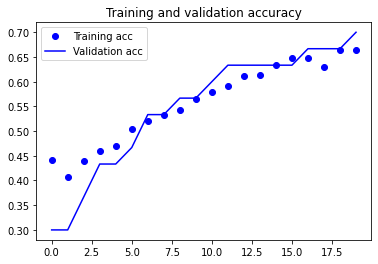

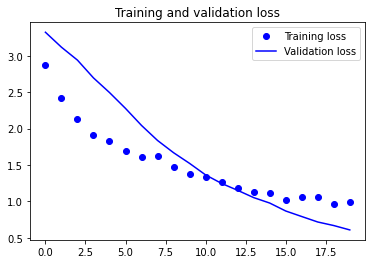

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine tuning last several layers.

In [32]:
# multiply_16
# set 'multiply_16' and following layers trainable
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [33]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/20
41/41 [==============================] - 103s 2s/step - loss: 0.8588 - acc: 0.6942 - val_loss: 0.5627 - val_acc: 0.7000
Epoch 2/20
41/41 [==============================] - 94s 2s/step - loss: 0.8440 - acc: 0.7008 - val_loss: 0.5260 - val_acc: 0.7000
Epoch 3/20
41/41 [==============================] - 94s 2s/step - loss: 0.8191 - acc: 0.7093 - val_loss: 0.4948 - val_acc: 0.7333
Epoch 4/20
41/41 [==============================] - 78s 2s/step - loss: 0.8315 - acc: 0.7036 - val_loss: 0.4641 - val_acc: 0.7333
Epoch 5/20
41/41 [==============================] - 77s 2s/step - loss: 0.8172 - acc: 0.7104 - val_loss: 0.4423 - val_acc: 0.7333
Epoch 6/20
41/41 [==============================] - 95s 2s/step - loss: 0.7845 - acc: 0.7206 - val_loss: 0.4153 - val_acc: 0.7667
Epoch 7/20
41/41 [==============================] - 95s 2s/step - loss: 0.7562 - acc: 0.7223 - val_loss: 0.3923 - val_acc: 0.7667
Epoch 8/20
41/41 [==============================] - 97s 2s/step - loss: 0.7691 - acc: 0.7

In [34]:
os.makedirs("./models", exist_ok=True)
model.save('./models/cats_and_dogs_small.h5')

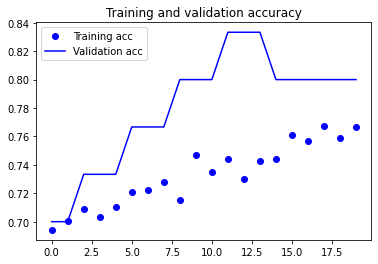

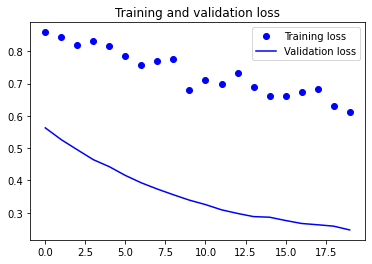

In [35]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Test predict

In [36]:
cat_img = cat_images[-1]
dog_img= dog_images[-1]

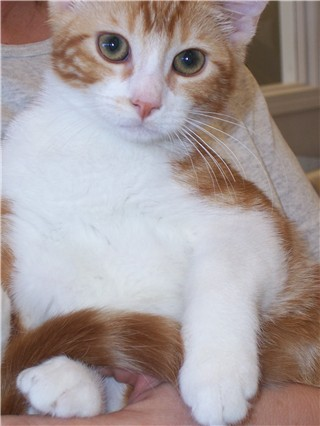

In [37]:
Image(filename=cat_img)

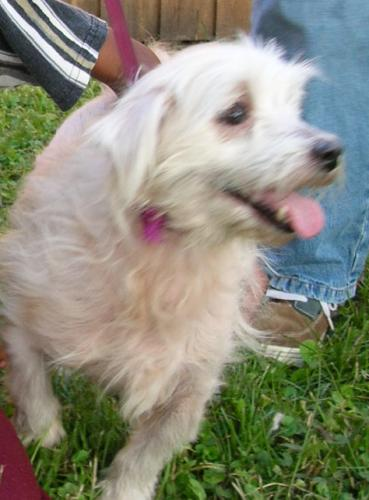

In [38]:
Image(filename=dog_img)

In [39]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])[0][0]
    if result > 0.5:
        animal = "cat"
    else:
        animal = "dog"
        result = 1 - result
    return animal,result

print(predict_image(cat_img))
print(predict_image(dog_img))

('cat', 0.9742882)
('dog', 0.9271175190806389)


## Download the model

In [40]:
from google.colab import files

files.download('./models/cats_and_dogs_small.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
model.input_shape

(None, 150, 150, 3)

## Load the model

In [42]:
from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [43]:
from tensorflow.keras.models import load_model
model = load_model("./models/cats_and_dogs_small.h5")